In [96]:
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import numpy as np
import pandas as pd
import os.path as op
import argparse
import re
from scipy import signal, stats
from sklearn.linear_model import LinearRegression

In [63]:
spectrums = pd.read_csv('spectrums2.csv')
accuracy = pd.read_csv('accuracy.csv', index_col = 0)

# Add accuracy group to dataframe
accuracy = accuracy.rename(columns = {'sub_num': 'subject'})
spectrums = spectrums.merge(accuracy, left_on = ["subject"], right_on = ["subject"])
np.unique(spectrums.subject)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45])

In [64]:
spectrums

,subject,target,stimulus,frequency,power,accuracy,group
0,3,130,130,0.000000,5.289240,0.785415,low
1,3,130,130,4.979253,5.347942,0.785415,low
2,3,130,130,9.958506,5.533879,0.785415,low
3,3,130,130,14.937759,5.417680,0.785415,low
4,3,130,130,19.917012,5.271016,0.785415,low
...,...,...,...,...,...,...,...
45733,45,280,280,577.593361,2.571565,0.977482,high
45734,45,280,280,582.572614,2.259651,0.977482,high
45735,45,280,280,587.551867,1.317281,0.977482,high
45736,45,280,280,592.531120,2.590665,0.977482,high


In [65]:
palette_tab10 = sns.color_palette("tab10", 10)

### Just FFRs

In [66]:
spectrums_sub = spectrums.groupby(['subject', 'stimulus', 'frequency'], as_index=False)['power'].mean()
spectrums_sub

,subject,stimulus,frequency,power
0,3,130,0.000000,10.870513
1,3,130,4.979253,10.824909
2,3,130,9.958506,11.347983
3,3,130,14.937759,10.709099
4,3,130,19.917012,10.824084
...,...,...,...,...
15241,45,280,577.593361,2.088504
15242,45,280,582.572614,0.254580
15243,45,280,587.551867,-0.184774
15244,45,280,592.531120,0.306909


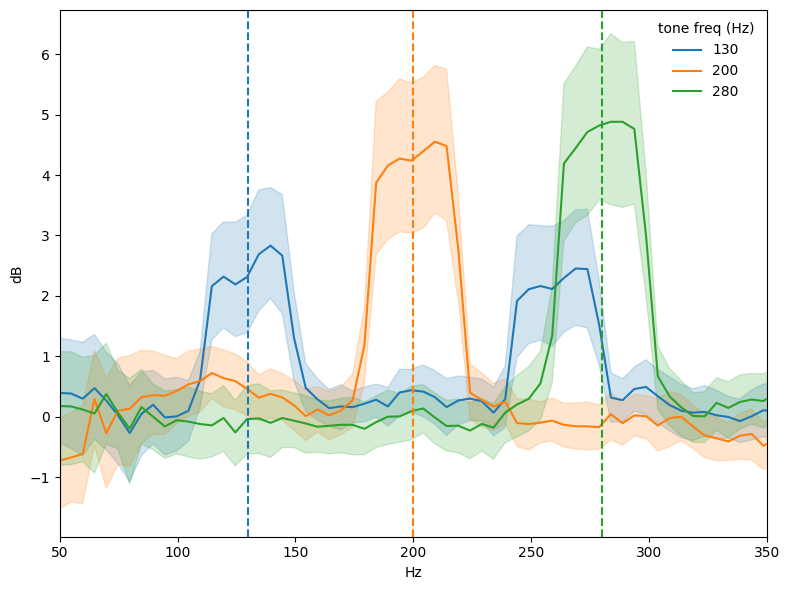

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))
spectrums_sub = spectrums.groupby(['subject', 'stimulus', 'frequency'], as_index=False)['power'].mean()
graph = sns.lineplot(data = spectrums_sub, x = "frequency", y = "power", hue = "stimulus", palette = 'tab10', ax = ax)
graph.axvline(130, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(200, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(280, linestyle = 'dashed', color = palette_tab10[2])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 350)
# graph.set_ylim(-2, 9)
plt.legend(frameon=False, title = 'tone freq (Hz)')
plt.tight_layout()
# plt.savefig('../figs/FFR.png')

### By accuracy

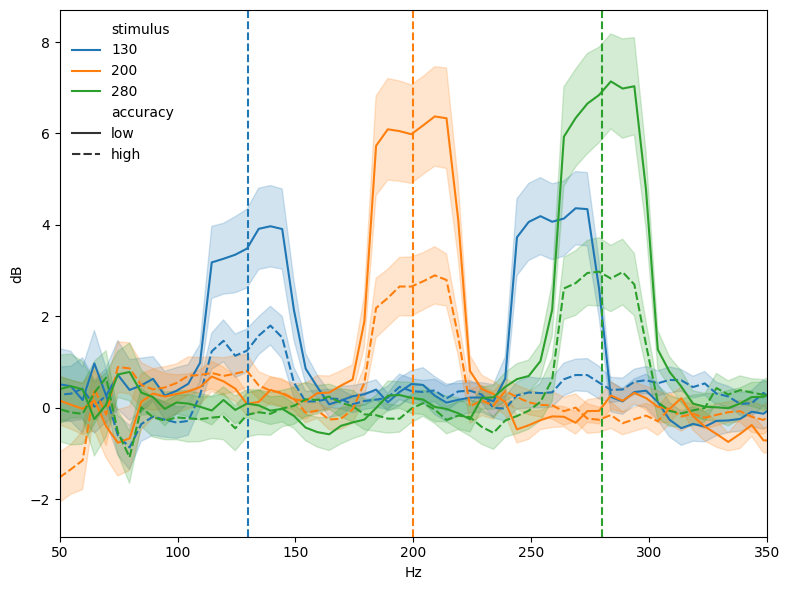

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))
spectrums_accuracy = spectrums.groupby(['subject', 'frequency', 'stimulus', 'group'], as_index=False)['power'].mean()
spectrums_accuracy['accuracy'] = spectrums_accuracy.group
graph = sns.lineplot(data = spectrums_accuracy, x = "frequency", y = "power", hue = "stimulus", style = "accuracy", palette = 'tab10', errorbar = 'se', ax = ax)
graph.axvline(130, linestyle = 'dashed', color = palette_tab10[0])
graph.axvline(200, linestyle = 'dashed', color = palette_tab10[1])
graph.axvline(280, linestyle = 'dashed', color = palette_tab10[2])
graph.set_ylabel("dB")
graph.set_xlabel("Hz")
graph.set_xlim(50, 350)
# graph.set_ylim(-2, 9)
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig('../figs/FFR-by-accuracy.png')


## Regressions

In [90]:
# get power at f0
stims = [130, 200, 280]
all_power_f0 = []

for stim in stims:    
    idx = np.abs(spectrums.frequency - target_freq).argmin()
    hz = spectrums.frequency[idx]
    power_f0 = spectrums[spectrums.frequency == hz]
    power_f0 = power_f0[power_f0.stimulus == stim]
    all_power_f0.append(power_f0)

all_power_f0 = pd.concat(all_power_f0)
all_power_f0

,subject,target,stimulus,frequency,power,accuracy,group
26,3,130,130,129.460581,2.126778,0.785415,low
389,3,200,130,129.460581,7.821449,0.785415,low
752,3,280,130,129.460581,6.387437,0.785415,low
1115,4,130,130,129.460581,3.763498,0.958154,high
1478,4,200,130,129.460581,4.520233,0.958154,high
...,...,...,...,...,...,...,...
44191,44,200,280,129.460581,-3.213974,0.885029,low
44554,44,280,280,129.460581,2.183360,0.885029,low
44917,45,130,280,129.460581,2.645030,0.977482,high
45280,45,200,280,129.460581,-3.172740,0.977482,high


-12.305616608726217 13.62301246022927 -0.1929758119972823 0.03039133649440678 5.6188670404208105
5.056119432667468 -4.184528885167589 0.1339609156727168 0.13479171082598013 3.3588929519140778
5.056119432667468 -4.184528885167589 0.1339609156727168 0.13479171082598013 3.3588929519140778


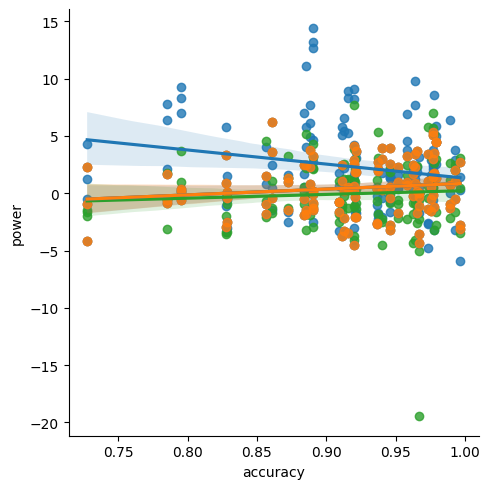

In [101]:
graph = sns.lmplot(data = all_power_f0, x = "accuracy", y = "power", hue = "stimulus", legend = False)

# 130 Hz tone
power_f0_130 = all_power_f0[all_power_f0.stimulus == 130]
# sns.regplot(data = power_f0_130, x="accuracy", y="power")
slope, intercept, r_value, p_value, std_err = stats.linregress(power_f0_130.accuracy, power_f0_130.power)
print(slope, intercept, r_value, p_value, std_err)

# 200 Hz tone
power_f0_200 = all_power_f0[all_power_f0.stimulus == 200]
sns.regplot(data = power_f0_200, x="accuracy", y="power")
slope, intercept, r_value, p_value, std_err = stats.linregress(power_f0_200.accuracy, power_f0_200.power)
print(slope, intercept, r_value, p_value, std_err)

# 280 Hz tone
power_f0_280 = all_power_f0[all_power_f0.stimulus == 200]
sns.regplot(data = power_f0_280, x="accuracy", y="power")
slope, intercept, r_value, p_value, std_err = stats.linregress(power_f0_280.accuracy, power_f0_280.power)
print(slope, intercept, r_value, p_value, std_err)

In [ ]:
# # get power at f0 and first harmonic
# stims = [130, 200, 280]
# all_power_f0 = []

# for stim in stims:    
#     idx = np.abs(spectrums.frequency - target_freq).argmin()
#     hz = spectrums.frequency[idx]
#     idx = np.abs(spectrums.frequency - target_freq*2).argmin()
#     hz_harmonic1 = spectrums.frequency[idx]
#     power_f0 = spectrums[(spectrums.frequency == hz) | (spectrums.frequency == hz_harmonic1)]
#     power_f0 = power_f0[power_f0.stim == stim]
# #     power_f0 = power_f0.groupby(['subject', 'target', 'stim', 'group'], as_index=False).accuracy.mean()

# #     all_power_f0.append(power_f0)
# # all_power_f0 = pd.concat(all_power_f0)